In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from util.df_concat import concat
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from util.furier_predictor import create_fourier_predictor

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

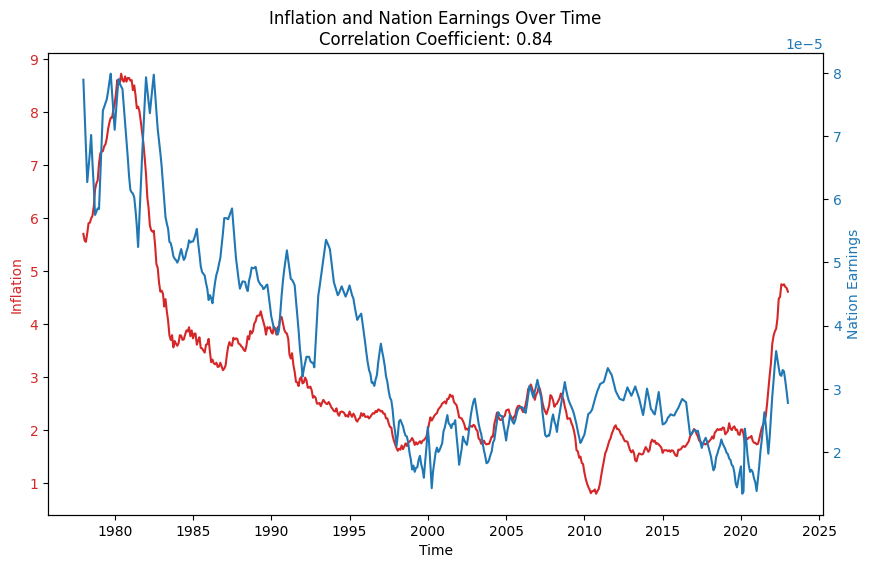

In [3]:
data = concat(
    './data/raw/PCETRIM12M159SFRBDAL.csv', # inflation                         | y
    './data/raw/UNRATE.csv',               # unemployment rate                 | x1
    './data/raw/PRS84006091.csv',          # labor productivity                | x2
    './data/raw/GDPC1.csv',                # real GDP(gross domestic product)  | x4
)

data['nationProductivity'] = data['PRS84006091'] / (1 - data['UNRATE'])

data['norm_nationProductivity'] = sigmoid(data['nationProductivity'])

data['nationEarnings'] = (data['norm_nationProductivity'] / (data['GDPC1'] + 1))

# Select the columns of interest
columns_of_interest = ['PCETRIM12M159SFRBDAL', 'nationEarnings']
selected_data = data[columns_of_interest]
selected_data.columns = ['inflation', 'nation Earnings']

selected_data.head().to_clipboard()
scaler = MinMaxScaler()
normalized_data = selected_data

# Calculate the correlation coefficient
correlation = normalized_data['inflation'].corr(normalized_data['nation Earnings'])

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'inflation'
ax1.set_xlabel('Time')
ax1.set_ylabel('Inflation', color='tab:red')
ax1.plot(normalized_data.index, normalized_data['inflation'], color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis to plot 'nation Earnings'
ax2 = ax1.twinx()
ax2.set_ylabel('Nation Earnings', color='tab:blue')
ax2.plot(normalized_data.index, normalized_data['nation Earnings'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add correlation coefficient to the plot
plt.title(f'Inflation and Nation Earnings Over Time\nCorrelation Coefficient: {correlation:.2f}')

# Show the plot
plt.show()

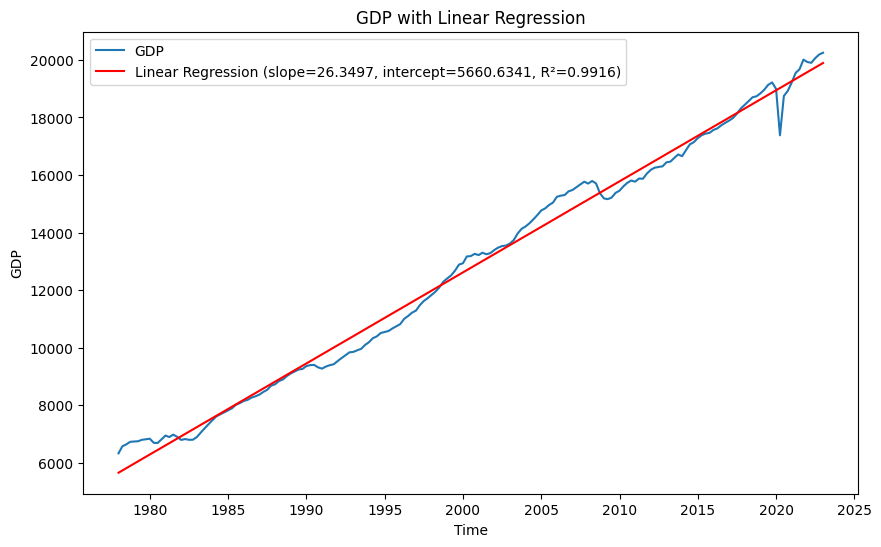

In [7]:
# approximate normolized gdp

gdp = data['GDPC1']
index_as_number = np.arange(len(gdp))

index_as_number = np.arange(len(gdp))
gdp.head().to_clipboard()
# Perform linear regression
slope, intercept = np.polyfit(index_as_number, gdp, 1)
linear_regression_line = slope * index_as_number + intercept

# Calculate the R-squared value
residuals = gdp - (slope * index_as_number + intercept)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((gdp - np.mean(gdp))**2)
r_squared = 1 - (ss_res / ss_tot)

# Plot the normalized GDP
plt.figure(figsize=(10, 6))
plt.plot(gdp.index, gdp, label='GDP')

# Plot the linear regression line
plt.plot(gdp.index, linear_regression_line, color='red', label=f'Linear Regression (slope={slope:.4f}, intercept={intercept:.4f}, R²={r_squared:.4f})')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('GDP')
plt.title('GDP with Linear Regression')
plt.legend()

# Show the plot
plt.show()

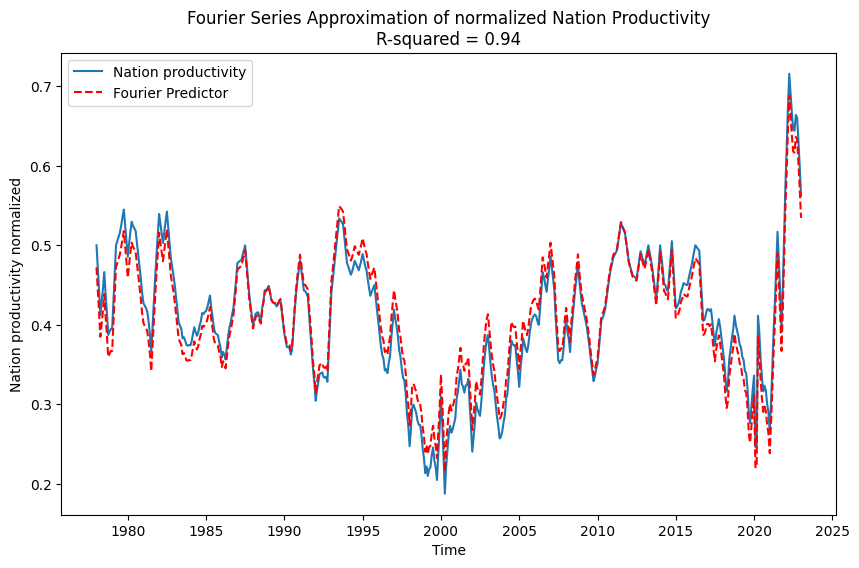

In [5]:
from sklearn.metrics import r2_score

nation_productivity = data['norm_nationProductivity']

def create_fourier_predictor(data, num_terms):
    num_samples = len(data)
    frequencies = np.fft.fftfreq(num_samples)
    fft_values = np.fft.fft(data)
    
    def fourier_series(t):
        f_approx = np.zeros_like(t, dtype=complex)
        for n in range(num_terms):
            coef = fft_values[n] / num_samples
            f_approx += coef * np.exp(1j * 2 * np.pi * frequencies[n] * t)
        real_part = np.real(f_approx)
        return real_part
    
    return fourier_series

# Create a Fourier series predictor
furier_predictor = create_fourier_predictor(nation_productivity, 540)

# Generate an array of time values (numerical indices)
time_values = np.arange(len(nation_productivity))

# Make predictions for each time value
predictions = [furier_predictor(t) for t in time_values]

# Calculate R-squared score
r2 = r2_score(nation_productivity, predictions)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(nation_productivity.index, nation_productivity, label='Nation productivity')
plt.plot(nation_productivity.index, predictions, color='red', label='Fourier Predictor', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Nation productivity normalized')
plt.title('Fourier Series Approximation of normalized Nation Productivity\nR-squared = {:.2f}'.format(r2))
plt.legend()
plt.show()

2023-01-01 00:00:00


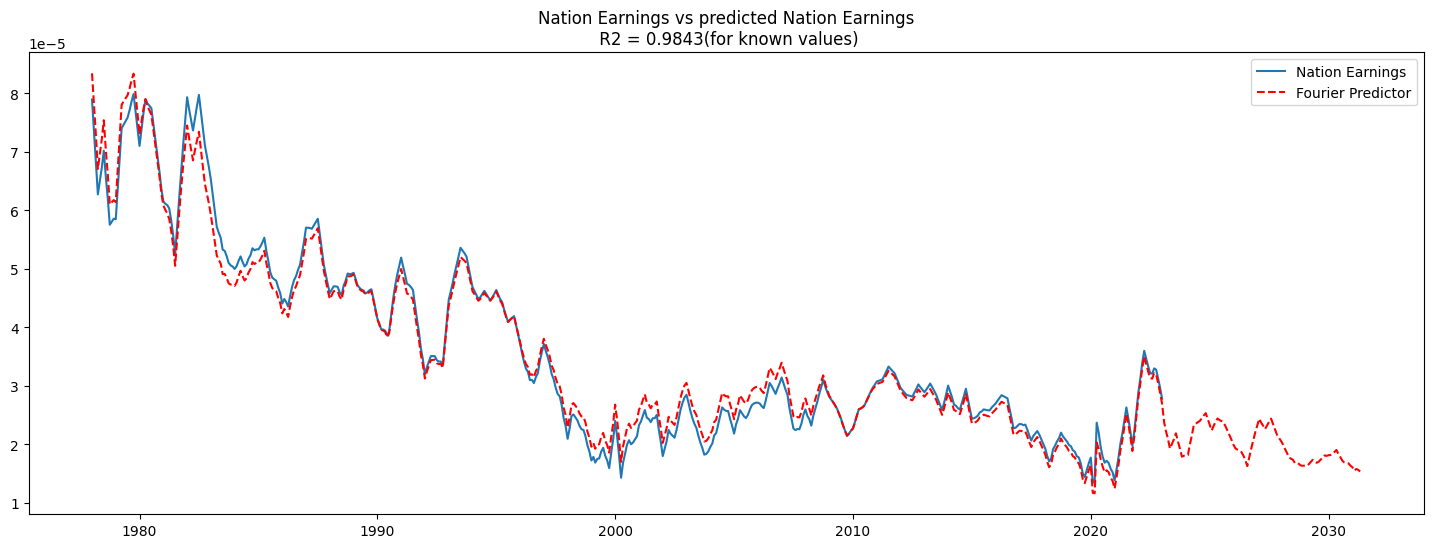

In [6]:
def predict_nationEarnings(t):
    nation_productivity = furier_predictor(t)
    gdp = slope * t + intercept
    nation_earnings = nation_productivity / (gdp + 1)

    return nation_earnings

nation_earnings = data['nationEarnings']
indexes = np.arange(len(nation_earnings))
indexes_ext = np.arange(len(nation_earnings) + 100)

predictions = [predict_nationEarnings(t) for t in indexes_ext]

indexes = data.index
indexes_ext = pd.date_range(start=indexes[0], periods=len(indexes) + 100, freq='MS')
print(max(indexes))

r2 = r2_score(nation_earnings, predictions[:len(nation_earnings)])
plt.figure(figsize=(18, 6))
plt.title(f'Nation Earnings vs predicted Nation Earnings\n R2 = {r2:.4f}(for known values)')
plt.plot(indexes, nation_earnings, label='Nation Earnings')
plt.plot(indexes_ext, predictions, color='red', label='Fourier Predictor', linestyle='dashed')
plt.legend()